## DataSet

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable

import os
import csv
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload

%autoreload 2
plt.ion()   # interactive mode



from torch.nn import Conv2d as Conv2D
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Upsample

import cv2
from torch.utils.data import Dataset

In [5]:
!gdown --id 1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
!gdown --id 1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl

Downloading...
From: https://drive.google.com/uc?id=1opMhHAiMJVdD0eYAJEcuHZgTscgFBCpj
To: /content/2d_images.zip.zip
102MB [00:01, 91.2MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1uVs0yvi-HRj0yyez9MbnGwk_EsCHDLzl
To: /content/2d_masks.zip.zip
100% 585k/585k [00:00<00:00, 75.8MB/s]


In [6]:
%mkdir Dataset
%mkdir Dataset/2d_images
%mkdir Dataset/2d_masks

In [7]:

!unzip -q 2d_images.zip.zip 
!unzip -q 2d_images.zip -d Dataset/2d_images

!unzip -q 2d_masks.zip.zip 
!unzip -q 2d_masks.zip -d Dataset/2d_masks

In [8]:
!rm -rf 2d_images.zip.zip
!rm -rf 2d_images.zip

!rm -rf 2d_masks.zip.zip
!rm -rf 2d_masks.zip

## DataLoader

In [2]:
class CT_Data(Dataset):

    def __init__(self, csv_file, root_dir):

        self.image_frame = pd.read_csv(csv_file, skiprows=1)
        self.root_dir = root_dir

    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):

        img_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 0])
        mask_name = os.path.join(self.root_dir, self.image_frame.iloc[idx, 1])
        image = cv2.imread(img_name, 0)
        image = cv2.resize(image,(32, 32))
        image = image.reshape((1, 32, 32))
        mask = cv2.imread(mask_name, 0)
        mask = cv2.resize(mask, (32, 32))
        mask = mask.reshape((1, 32, 32))
        sample = {'image': image, 'mask': mask}
        return sample

In [3]:
img_dir = "Dataset/2d_images/"
msk_dir = "Dataset/2d_masks/"
with open('Dataset/Dataset.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename", "mask"])
    for p in os.listdir(img_dir):
        image_path = os.path.join(img_dir, p)
        mask_path = os.path.join(msk_dir, p)
        writer.writerow([image_path, mask_path])


data = pd.read_csv("Dataset/Dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
partition = int(len(data)*0.7)
train, validation = data[:partition], data[partition:]
train.to_csv("Dataset/Train.csv", index=False)
validation.to_csv("Dataset/Validation.csv", index=False)

train_dataset = CT_Data(csv_file='Dataset/Train.csv', root_dir='/content')
val_dataset = CT_Data(csv_file='Dataset/Validation.csv', root_dir='/content')
train_dataloader = DataLoader(train_dataset, batch_size=37, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True, num_workers=4)

## U-Net Model

In [4]:

class Up(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Up, self).__init__()

        ###########################################
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_in, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(inplace=True),
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
        ###########################################

    def forward(self, x1, x2):

        ###########################################
        x1 = self.upsample(x1)
        diff_X = x1.size()[2] - x2.size()[2]
        diff_Y = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diff_X // 2, int(diff_X / 2),diff_Y // 2, int(diff_Y / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x  
        ###########################################

class Down(nn.Module):
    def __init__(self, channel_in, channel_out):
        super(Down, self).__init__()

        ###########################################
        self.conv = nn.Sequential(
            Conv2D(channel_in, channel_in, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(inplace=True),
            Conv2D(channel_in, channel_out, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_out),
            nn.ReLU(inplace=True)
        )
        ###########################################
    
    def forward(self, x):

        ###########################################
        x = F.max_pool2d(x,2)
        x = self.conv(x)
        return x
        ###########################################

class UNet(nn.Module):
    def __init__(self, channel_in, classes):
        super(UNet, self).__init__()

        ###########################################
        self.input_conv = nn.Sequential(
            Conv2D(channel_in, channel_in, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(channel_in),
            nn.ReLU(inplace=True),
            Conv2D(channel_in, 64, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512,512)
        self.up1 = Up(1024,256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 32)
        self.output_conv = nn.Conv2d(32, classes, kernel_size = 1)  
        ###########################################
        
    def forward(self, x):
        
        ###########################################
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5,x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        output = self.output_conv(x)
        return F.sigmoid(output)
        ###########################################
    
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight, gain=numpy.sqrt(2.0))
        init.constant(m.bias, 0.1)




## Training

In [5]:
def iou_score(output, target):
    smooth = 1e-8
    oss = output > 0.5
    tss = target > 0.5
    intersection = (oss & tss).sum(axis=[1,2,3])
    union = (oss | tss).sum(axis=[1,2,3])
    return ((intersection + smooth) / (union + smooth)).mean()

In [6]:
freq = 1
model = UNet(1, 1)


optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()

def train(model, epoch):
    ###########################################
    model.train()
    correct = 0
    ########### Set model to train mode
    ###########################################
    for batch_idx, data in enumerate(train_dataloader):
        ###########################################
        data, target = Variable(data["image"]), Variable(data["mask"])
        # print(f"unique:{torch.unique(target)}")
        min_v = torch.min(target)
        range_v = torch.max(target) - min_v
        target = (target - min_v) / range_v
        # print(f"unique:{torch.unique(normalised)}")
        
        optimizer.zero_grad()
        output = model.forward(data.float())
        # print(f"unique:{torch.unique(output)}")
        loss = criterion(output.float(), target.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ###########################################

        ###########################################
        if batch_idx % freq == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_dataloader.dataset)}'
            f' ({100. * batch_idx / len(train_dataloader):.0f}%)]\tLoss: { loss.data:.6f}')
        ########### Print loss and accuracy for train
        ###########################################

def test(model):
    ###########################################
    model.eval()
    ########### Set model to validation mode
    ###########################################
    test_loss = 0
    total_iou = 0.0
    for data in val_dataloader:
        ###########################################
        data, target = Variable(data["image"], volatile=True), Variable(data["mask"])
        output = model(data.float())
        # print(output.data[0])
        min_v = torch.min(target)
        range_v = torch.max(target) - min_v
        target = (target - min_v) / range_v
        test_loss += criterion(output.float(), target.float()).data # sum up batch loss
        total_iou += iou_score(output, target)
    test_loss /= len(val_dataloader.dataset)
    total_iou /= len(val_dataloader)
    print(f"Average Loss: {test_loss} and IoU : {total_iou}")
        ########### calculate and Print loss and accuracy for test(or validation)
        ###########################################


Num_of_eopchs = 20

for epoch in range(1, Num_of_eopchs+1):
    train(model, epoch)
    test(model)


Train Epoch: 1 [0/185 (0%)]	Loss: 0.795207
Train Epoch: 1 [37/185 (20%)]	Loss: 0.697212
Train Epoch: 1 [74/185 (40%)]	Loss: 0.639077
Train Epoch: 1 [111/185 (60%)]	Loss: 0.606457
Train Epoch: 1 [148/185 (80%)]	Loss: 0.559028
Average Loss: 0.03519650548696518 and IoU : 0.24913054704666138
Train Epoch: 2 [0/185 (0%)]	Loss: 0.523921
Train Epoch: 2 [37/185 (20%)]	Loss: 0.491464
Train Epoch: 2 [74/185 (40%)]	Loss: 0.491018
Train Epoch: 2 [111/185 (60%)]	Loss: 0.464413
Train Epoch: 2 [148/185 (80%)]	Loss: 0.457676
Average Loss: 0.033617351204156876 and IoU : 0.21056808531284332
Train Epoch: 3 [0/185 (0%)]	Loss: 0.444232
Train Epoch: 3 [37/185 (20%)]	Loss: 0.435304
Train Epoch: 3 [74/185 (40%)]	Loss: 0.431345
Train Epoch: 3 [111/185 (60%)]	Loss: 0.407353
Train Epoch: 3 [148/185 (80%)]	Loss: 0.418745
Average Loss: 0.031244149431586266 and IoU : 0.018231166526675224
Train Epoch: 4 [0/185 (0%)]	Loss: 0.402628
Train Epoch: 4 [37/185 (20%)]	Loss: 0.400667
Train Epoch: 4 [74/185 (40%)]	Loss: 0.4039

## Visualization


visualize output of your trained network on 5 data from validation dataset, and compare it with ground truth.

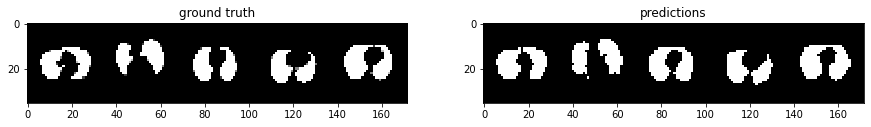

In [7]:

# get some random training images
dataiter = iter(val_dataloader)
batch = dataiter.next()
images, labels = batch['image'], batch['mask']
with torch.no_grad():
  outputs = model(images.float())

def show(img, ax):
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

out_samples = outputs[:5]
label_samples = labels[:5]
pred_grid = utils.make_grid(255*(out_samples >= 0.5) , nrow=5)
gt_grid = utils.make_grid(label_samples , nrow=5)
f, (ax0,ax1) = plt.subplots(1,2,figsize=(15,15))
ax0.set_title('ground truth')
ax1.set_title('predictions')
show(gt_grid, ax0)
show(pred_grid, ax1)


## Improve U-Net (bonus)

improve U-Net and compare accuracy and networks outputs with previous parts.